# Overview
## Autism Spectrum Disorder
Autism Spectrum Disorder (ASD) is a developmental disability that affects how a person experiences the world. Autism affects the way a person thinks, communicates, and socializes. It's important to note that these differences do not indicate that something is wrong with the person and autism is not something to be cured. Autism is a part of who a person is, and treatment for it is about learning how to live with the disorder in a neurotypical world, not about removing or changing aspects of who someone is. For more information about autism, refer to [this page on the Autistic Self Advocacy Network website.](https://autisticadvocacy.org/about-asan/about-autism/)

## Not A Diagnostic Tool
We've made a few models that predict whether a child is diagnosed with ASD or not. These models are useful primarily to extract feature importance from, and not as actual predictors. **None of our models can be used for diagnosis, and if you think you have a disorder, then you should speak with a mental health professional about it.**

## Our Goal
Our goal is to analyze factors that may indicate someone is autistic in order to push people who may be autistic to get diagnosed. Diagnosis can be an important step for improving quality of life in autistic people; once a person knows they're autistic and what that looks like for them, it allows them to learn coping strategies in order to better navigate the neurotypical world that we live in.

## The Data
Data about ASD can be difficult to find, so we're using topical data from the [National Survey of Children's Health.](https://www.census.gov/programs-surveys/nsch/data/datasets.html) This data has a few limitations, but will work for our purpose. The main limitations are:
- The data is only collected about children. This a problem that pervades a lot of research about autism; it's often only studied in children despite the fact that autistic children grow up into autistic adults.
- The variables related to autism rely on a diagnosis from a medical professional. This is a limitation because autism often goes undiagnosed, and some people realize they or their child are autistic and choose not to get diagnosed for various reasons.
- The portion of children diagnosed with autism is very small, which means we need to address this class imbalance in our modeling.

# Methods
What we want to do is look at factors that could indicate that someone is autistic. In order to do this, we're going to make predictive models and examine the features those models deem most impactful.

#### Considerations:
- Since our goal is interpretation, we'll want to tend toward simpler models.
- Since ASD is uncommon, we'll need to account for the class imbalance. This means not using accuracy as a primary metric; since a model that guesses nobody is autistic has a 97% accuracy.
- False positives are unreliable as it's impossible to know what portion of them are undiagnosed autistic children. This means precision isn't a very useful metric on its own.
- Recall is likely to be our most reliable metric.

### Preprocessing
Below we import necessary classes and functions and set the pandas display options to show all columns in a dataframe since we have so many columns. Then we define a function that can display metrics showing how a model is performing.

In [1]:
#Initial imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, plot_roc_curve, precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, StackingRegressor, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

# Set pandas to display all columns, since our data has many columns and we'd like to see them all
pd.set_option('display.max_columns', None)

In [2]:
def display_metrics(fit_model, Xtr, Xte, ytr, yte):
    '''
    This function takes in a model that's already been fit, then X and y train and test data.
    It uses the fitted model to get predicted values for the train and test data,
    and then uses sklearn's score functions to print out the accuracy, recall, precision,  f1, and roc-auc scores.
    It then plots a confusion matrix of the test data.
    '''
    train_preds = fit_model.predict(Xtr)
    test_preds = fit_model.predict(Xte)
    train_probs = fit_model.predict_proba(Xtr)[:,1]
    test_probs = fit_model.predict_proba(Xte)[:,1]

    train_accuracy = accuracy_score(ytr, train_preds)
    test_accuracy = accuracy_score(yte, test_preds)
    train_recall = recall_score(ytr, train_preds, zero_division=0)
    test_recall = recall_score(yte, test_preds, zero_division=0)
    train_precision = precision_score(ytr, train_preds, zero_division=0)
    test_precision = precision_score(yte, test_preds, zero_division=0)
    train_f1 = f1_score(ytr, train_preds, zero_division=0)
    test_f1 = f1_score(yte, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(ytr, train_probs)
    test_rocauc = roc_auc_score(yte, test_probs)

    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    
    plot_confusion_matrix(fit_model, Xte, yte, values_format='6g')
    plot_roc_curve(fit_model, Xte, yte)

Now that we've got our imports, we need to read in the dataframe and create our target column.

In [3]:
# Read in dataframe
df = pd.read_sas('data/nsch_2020_topical.sas7bdat')

# Map target column to boolean and rename to target
mask = {
    1.0: 1.0,
    2.0: 0.0
}
df['Target'] = df['K2Q35A'].map(mask)

# Drop rows where target is null
df.dropna(subset=['Target'], inplace=True)

We had 443 columns, most of which had null values. We couldn't drop all of the null values or we'd lose a large chunk of our data, so instead we read through the [NSCH topical variable descriptions](https://www2.census.gov/programs-surveys/nsch/technical-documentation/codebook/2020-NSCH-Topical-Variable-List.pdf) and determined how to handle each column. See [this notebook](https://github.com/pjlannoo/ASD-Factors-ML/blob/main/Notebooks/DataNotes.ipynb) for details about why each column was handled the way it was. Below we define where each column goes.

In [4]:
# Define which columns to drop
drop_cols = [
    'A1_ACTIVE', 'A1_AGE', 'A1_BORN', 'A1_DEPLSTAT', 'A1_EMPLOYED', 'A1_GRADE', 'A1_LIVEUSA', 'A1_MARITAL',
    'A1_MENTHEALTH', 'A1_PHYSHEALTH', 'A1_RELATION', 'A1_SEX', 'A2_ACTIVE', 'A2_AGE', 'A2_BORN', 'A2_DEPLSTAT', 
    'A2_EMPLOYED', 'A2_GRADE', 'A2_LIVEUSA', 'A2_MARITAL', 'A2_MENTHEALTH', 'A2_PHYSHEALTH', 'A2_RELATION', 'A2_SEX', 
    'ALLERGIES_DESC', 'ARTHRITIS_DESC', 'ASKQUESTION', 'ASKQUESTION2', 'AUTISMMED', 'AUTISMTREAT', 'BESTFORCHILD', 
    'BLOOD_DESC', 'BMICLASS', 'BREASTFEDEND_DAY_S', 'BREASTFEDEND_MO_S', 'BREASTFEDEND_WK_S', 'CALMDOWN', 'CERPALS_DESC',
    'CLEAREXP', 'COLOR', 'CONFIDENT', 'COUNTTO', 'DIRECTIONS', 'DIRECTIONS2', 'DISCUSSOPT', 'DISTRACTED', 'DOCPRIVATE',
    'FAMCOUNT', 'FIPSST', 'FORMTYPE', 'FRSTFORMULA_DAY_S', 'FRSTFORMULA_MO_S','FRSTFORMULA_WK_S', 'FRSTSOLIDS_DAY_S', 
    'FRSTSOLIDS_MO_S', 'FRSTSOLIDS_WK_S', 'GENETIC_DESC', 'HCEXTENT', 'HEADACHE_DESC', 'HEART_DESC', 'HHCOUNT',
    'HHCOUNT_IF', 'HHID', 'HOURSLEEP', 'HOURSLEEP05', 'HURTSAD', 'K12Q01_A', 'K12Q01_B', 'K12Q01_C', 'K12Q01_D', 
    'K12Q01_E', 'K12Q01_F', 'K12Q01_G', 'K2Q30C', 'K2Q31C', 'K2Q32C', 'K2Q33C', 'K2Q34C', 'K2Q35A', 'K2Q35A_1_YEARS', 
    'K2Q35B', 'K2Q35C', 'K2Q35D', 'K2Q36C', 'K2Q37C', 'K2Q38C', 'K2Q40C', 'K2Q41C', 'K2Q42C', 'K2Q60C', 'K4Q26',
    'K4Q28X_EAR','K4Q37', 'K5Q11','K5Q21', 'K5Q22', 'K5Q32','K6Q08_R','K6Q10','K6Q12','K6Q13A','K6Q13B','K6Q14A','K6Q14B',
    'K6Q20','K6Q27', 'K6Q40', 'K6Q41R_STILL','K6Q42R_NEVER','K6Q43R_NEVER','K6Q60_R','K6Q61_R','K6Q70_R','K6Q72_R',
    'K6Q73_R','K9Q41', 'KEEPINSADULT','LIVEUSA_MO','LIVEUSA_YR','LIVEUSA_YR', 'K6Q42R_NEVER','MEDHISTORY','NEWACTIVITY',
    'ONEWORD','PLANNEEDS_R','PLAYWELL','POINT','RAISECONC','RECEIVECOPY','RECOGABC','RECOGBEGIN','RECSHAPES','RHYMEWORD',
    'SC_K2Q11','SC_K2Q12','SC_K2Q14','SC_K2Q15','SC_K2Q17','SC_K2Q18','SC_K2Q20','SC_K2Q21','SC_K2Q23','SC_RACEAIAN',
    'SC_RACEASIA','SESPLANMO','SESPLANYR','SIMPLEINST','SITSTILL','SLEEPPOS', 'SPCSERVMO','STARTSCHOOL','STRATUM',
    'TELLSTORY','TEMPER','THREEWORDS','TREATADULT', 'TREATNEED', 'TWOWORDS','UNDERSTAND', 'UNDERSTAND2', 'USEPENCIL', 
    'WORKTOFIN', 'WRITENAME', 'HEALTHKNOW', 'K8Q35', 'EMOSUPSPO', 'EMOSUPFAM', 'EMOSUPHCP', 'EMOSUPWOR', 'EMOSUPADV', 
    'EMOSUPPEER', 'EMOSUPMHP', 'EMOSUPOTH', 'K3Q20', 'K3Q22', 'K3Q21B', 'K7Q02R_R', 'DOCROOM', 'K4Q02_R', 'DENTISTVISIT', 
    'FWC', 'A1_GRADE_IF', 'FPL_IF', 'HIGRADE_TVIS', 'HIGRADE', 'INSTYPE', 'INSGAP', 'CURRINS', 'HOUSE_GEN', 'SC_SEX_IF', 
    'SC_HISPANIC_R_IF', 'SC_RACE_R_IF', 'TOTFEMALE', 'TOTMALE', 'AGEPOS4', 'SC_AGE_LT10', 'SC_AGE_LT9', 'SC_AGE_LT6', 
    'SC_AGE_LT4', 'TOTNONSHCN', 'TOTCSHCN', 'TOTAGE_12_17', 'TOTAGE_6_11', 'TOTAGE_0_5', 'MPC_YN', 'YEAR', 'K3Q04_R', 
    'TENURE'
]

# Define which cols to impute with no
no_cols = [
    'SC_SEX', 'K4Q32X01', 'K4Q32X02', 'K4Q32X03', 'K4Q32X04', 'K4Q32X05', 'DENTALSERV1', 'DENTALSERV2', 'DENTALSERV3',
    'DENTALSERV4', 'DENTALSERV5', 'DENTALSERV6', 'DENTALSERV7', 'K4Q28X01', 'K4Q28X02', 'K4Q28X03', 'K4Q28X04', 'K4Q28X05',
    'BREATHING', 'SWALLOWING', 'STOMACH', 'PHYSICALPAIN', 'HANDS', 'COORDINATION', 'TOOTHACHES', 'GUMBLEED', 'CAVITIES',
    'MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'ERRANDALONE', 'K2Q43B', 'BLINDNESS', 'ALLERGIES', 'ALLERGIES_CURR',
    'ARTHRITIS', 'ARTHRITIS_CURR', 'K2Q40A', 'K2Q40B', 'K2Q61A', 'K2Q61B', 'K2Q41A', 'K2Q41B', 'K2Q42A', 'K2Q42B', 'HEART',
    'HEART_BORN', 'HEART_CURR', 'HEADACHE', 'HEADACHE_CURR', 'K2Q38A', 'K2Q38B', 'K2Q33A', 'K2Q33B', 'K2Q32A', 'K2Q32B',
    'DOWNSYN', 'BLOOD', 'SICKLECELL', 'THALASSEMIA', 'BLOOD_OTHER', 'BLOOD_SCREEN', 'CYSTFIB', 'CYSTFIB_SCREEN', 'GENETIC',
    'GENETIC_SCREEN', 'K2Q34A', 'K2Q34B', 'K2Q36A', 'K2Q36B', 'K2Q60A', 'K2Q60B', 'K2Q37A', 'K2Q37B', 'K2Q30A', 'K2Q30B',
    'K2Q31A', 'K2Q31B', 'K2Q31D', 'ADDTREAT', 'CONCUSSION', 'SEEKCARE', 'CONFIRMINJURY', 'K2Q05', 'OVERWEIGHT', 'K4Q01',
    'USUALGO', 'USUALSICK', 'K4Q31_R', 'K4Q23', 'ALTHEALTH', 'K4Q27', 'NOTELIG', 'AVAILABLE', 'APPOINTMENT', 'TRANSPORTCC',
    'NOTOPEN', 'ISSUECOST', 'HOSPITALSTAY', 'SESCURRSVC', 'K4Q36', 'K4Q38', 'K5Q10', 'DECISIONS', 'K12Q03', 'K12Q04',
    'K12Q12', 'TRICARE', 'K11Q03R', 'HCCOVOTH', 'K3Q25', 'REPEATED', 'K7Q30', 'K7Q31', 'K7Q32', 'K7Q37', 'K7Q38', 'ACE3',
    'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'ACE12', 'ACE1', 'K7Q04R_R', 'WGTCONC', 'K4Q22_R', 'K4Q24_R',
    'K4Q04_R', 'K5Q31_R',  'BIRTHWT', 'BIRTHWT_L', 'BIRTHWT_VL', 'SC_K2Q22', 'SC_K2Q19', 'SC_K2Q16', 'SC_K2Q13',
    'SC_K2Q10', 'SC_CSHCN', 'K4Q30_R'
]

# Define which cols to impute with yes
yes_cols = [
    'S4Q01', 'CURRCOV', 'BORNUSA'
]

# Define which cols to impute with mode
mode_cols = [
    'HHLANGUAGE', 'K9Q40', 'K11Q60', 'K11Q61', 'K11Q62', 'S9Q34', 'K10Q11', 'K10Q12', 'K10Q13', 'K10Q14', 'K10Q20',
    'K10Q22', 'K10Q23', 'K9Q96', 'BULLIED_R', 'BULLY', 'TOTKIDS_R', 'SC_AGE_YEARS', 'BIRTH_MO', 'BIRTH_YR', 'SC_RACER', 
    'SC_RACE_R'
]

# Define which cols to impute with median
med_cols = [
    'MOMAGE', 'K11Q43R', 'K2Q01', 'K2Q01_D', 'K6Q71_R', 'TALKABOUT', 'WKTOSOLVE', 'STRENGTHS', 'HOPEFUL', 'K10Q30',
    'K10Q31', 'K10Q40_R', 'GOFORHELP', 'K10Q41_R', 'HOWMUCH', 'K8Q31', 'K8Q32', 'K8Q34', 'ATHOMEHC', 'ARRANGEHC',
    'SCREENTIME', 'K8Q11', 'HCABILITY', 'K8Q30', 'FAMILY_R', 'BIRTHWT_OZ_S', 'SC_ENGLISH', 'MAKEFRIEND',
    'BEDTIME', 'K7Q33'
]

# Define which cols to impute with median and add null flag
med_flag_cols = [
    'K5Q40', 'K5Q41', 'K5Q42', 'K5Q43', 'K5Q44', 'FOODSIT', 'MENBEVCOV'
]

# Define which cols to impute with constant 5
five_cols = [
    'K7Q84_R', 'K7Q85_R', 'K7Q82_R', 'K7Q83_R', 'K7Q70_R', 'K8Q21'
]

# Define lists to be used later

bool_two_no = [
    'SC_SEX', 'K4Q32X01', 'K4Q32X02', 'K4Q32X03', 'K4Q32X04', 'K4Q32X05', 'DENTALSERV1', 'DENTALSERV2', 'DENTALSERV3', 
    'DENTALSERV4', 'DENTALSERV5', 'DENTALSERV6', 'DENTALSERV7', 'K4Q28X01', 'K4Q28X02', 'K4Q28X03', 'K4Q28X04',
    'K4Q28X05', 'BREATHING', 'SWALLOWING', 'STOMACH', 'PHYSICALPAIN', 'HANDS', 'COORDINATION', 'TOOTHACHES', 'GUMBLEED', 
    'CAVITIES', 'MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'ERRANDALONE', 'K2Q43B', 'BLINDNESS', 'BLINDNESS', 'ALLERGIES', 
    'ALLERGIES_CURR', 'ARTHRITIS', 'ARTHRITIS_CURR', 'K2Q40A', 'K2Q40B', 'K2Q61A', 'K2Q61B', 'K2Q41A', 'K2Q41B', 'K2Q41A', 
    'K2Q41B', 'K2Q42A', 'K2Q42B', 'HEART', 'HEART_BORN', 'HEART_CURR', 'HEADACHE', 'HEADACHE_CURR', 'K2Q38A', 'K2Q38B', 
    'K2Q33A', 'K2Q33B', 'K2Q32A', 'K2Q32B', 'DOWNSYN', 'BLOOD', 'SICKLECELL', 'THALASSEMIA', 'BLOOD_OTHER', 'BLOOD_SCREEN',
    'CYSTFIB', 'CYSTFIB_SCREEN', 'GENETIC', 'GENETIC_SCREEN', 'K2Q34A', 'K2Q34B', 'K2Q36A', 'K2Q36B', 'K2Q60A', 'K2Q60B',
    'K2Q37A', 'K2Q37B', 'K2Q30A', 'K2Q30B', 'K2Q31A', 'K2Q31B', 'K2Q31D', 'ADDTREAT', 'CONCUSSION', 'SEEKCARE', 
    'CONFIRMINJURY', 'K2Q05', 'OVERWEIGHT', 'K4Q01', 'USUALGO', 'USUALSICK', 'K4Q31_R', 'K4Q23', 'ALTHEALTH', 'K4Q27',
    'NOTELIG', 'AVAILABLE', 'APPOINTMENT', 'TRANSPORTCC', 'NOTOPEN', 'ISSUECOST', 'HOSPITALSTAY', 'SESCURRSVC', 'K4Q36',
    'K4Q38', 'K5Q10', 'DECISIONS', 'K12Q03', 'K12Q04', 'K12Q12', 'TRICARE', 'K11Q03R', 'HCCOVOTH', 'K3Q25', 'REPEATED',
    'K7Q30', 'K7Q31', 'K7Q32', 'K7Q37', 'K7Q38', 'ACE3', 'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'ACE12',
    'ACE1', 'K4Q22_R', 'K4Q24_R', 'K5Q31_R', 'BIRTHWT', 'BIRTHWT_VL', 'SC_K2Q22', 'SC_K2Q19', 'SC_K2Q16', 'SC_K2Q13', 
    'SC_K2Q10', 'SC_CSHCN', 'S4Q01', 'CURRCOV', 'BORNUSA'
]
bool_two_yes = ['K7Q04R_R', 'WGTCONC', 'K4Q04_R', 'BIRTHWT', 'K4Q30_R']

use_cols = [*no_cols, *yes_cols, *mode_cols, *med_cols, *med_flag_cols, *five_cols]

# Adds remaining columns with many nulls to drop cols
for col in df.columns:
    if col not in use_cols and col not in drop_cols:
        if (df[col].isna().sum() / len(df)) > .5:
            drop_cols.append(col)

Below we map our boolean columns to 0 and 1, since they started as 1 and 2; then we define the steps of our preprocessor.

In [5]:
# Map boolean columns to boolean
bool_mask_1 = {
    1: 1,
    2: 0,
    3: 0
}
bool_mask_2 = {
    1: 1,
    2: 1,
    3: 0
}
for col in bool_two_no:
    df[col] = df[col].map(bool_mask_1)
for col in bool_two_yes:
    df[col] = df[col].map(bool_mask_2)

# Define imputers to make up preprocessor
no_imp = Pipeline(steps=[
    ('no_imp', SimpleImputer(strategy='constant', fill_value=0))
])
yes_imp = Pipeline(steps=[
    ('yes_imp', SimpleImputer(strategy='constant', fill_value=1))
])
mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent'))
])
med_imp = Pipeline(steps=[
    ('med_imp', SimpleImputer(strategy='median'))
])
med_flag_imp = Pipeline(steps=[
    ('med_flag_imp', SimpleImputer(strategy='median', add_indicator=True))
])
five_imp = Pipeline(steps=[
    ('five_imp', SimpleImputer(strategy='constant', fill_value=5))
])

And now that the steps are made, we put them together into a column transformer, and split our dataframe into X and y and then into train and test data.

In [6]:
# Create full preprocessor
full_preprocessor = ColumnTransformer(transformers=[
    ('no_pre', no_imp, no_cols),
    ('yes_pre', yes_imp, yes_cols),
    ('mode_pre', mode_imp, mode_cols),
    ('med_cols', med_imp, med_cols),
    ('med_flag_cols', med_flag_imp, med_flag_cols),
    ('five_cols', five_imp, five_cols)
])

In [7]:
# Drop the dropcols
df = df.drop(columns=[*drop_cols])

# Split to x and y
y = df['Target']
X = df.drop(columns=['Target'])

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

Since we have a class imbalance, we'll use an undersampler for some of our models, so we'll also define that and then our undersampled X and y train values.

In [9]:
under_sampler = RandomUnderSampler(random_state=42, replacement=True)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train, y_train)

### Modeling
Now that we have our preprocessor, we can start modeling. We'll want to explore various model types to see what we'll want to focus on. Let's start with a logistic regression.

#### Logistic Regression
We'll make a logistic regression on the full dataframe and then one on the undersampled data to see the difference in performance. Let's start with the full dataframe.


Train Accuracy:		0.9807872833093435
Test Accuracy:		0.9784098376044307

Train Recall:		0.5247108307045215
Test Recall:		0.5173501577287066

Train Precision:	0.7549167927382754
Test Precision:		0.6804979253112033

Train f1:		0.6191066997518611
Test f1:		0.5878136200716846

Train ROC-AUC:		0.9759786272608908
Test ROC-AUC:		0.9625214252229202


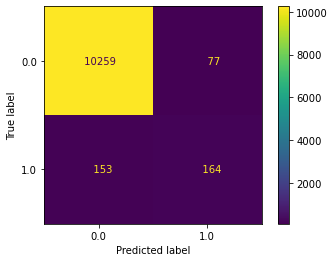

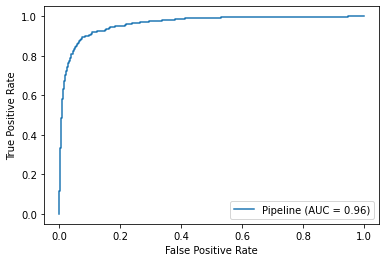

In [10]:
full_logreg = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])
full_logreg.fit(X_train, y_train)
display_metrics(full_logreg, X_train, X_test, y_train, y_test)

This model is not terrible, but we wanna improve on that recall score. Let's try the undersampled data.


Train Accuracy:		0.9008698917328994
Test Accuracy:		0.8989955880972496

Train Recall:		0.9390115667718192
Test Recall:		0.8706624605678234

Train Precision:	0.22308268798401198
Test Precision:		0.21052631578947367

Train f1:		0.3605167541380702
Test f1:		0.33906633906633904

Train ROC-AUC:		0.9692255305329955
Test ROC-AUC:		0.9413003828461486


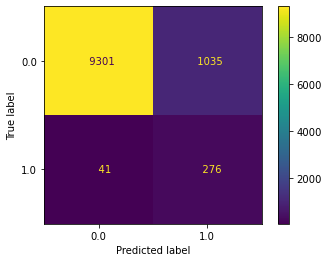

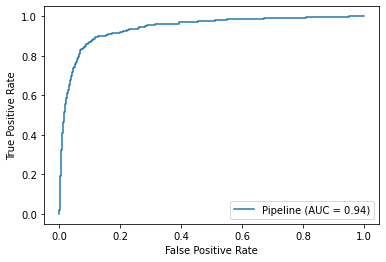

In [11]:
undersampled_logreg = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])
undersampled_logreg.fit(X_train_undersampled, y_train_undersampled)
display_metrics(undersampled_logreg, X_train, X_test, y_train, y_test)

This model has a better recall, and worse precision; which works for our purposes. That said, let's explore other models before looking at more logistic regressions.
#### Naive Bayes
Naive bayes models make the assumption that the features are all independent from each other. This is not true in our case, as we have many questions that follow from previous ones. This means we're violating the assumption that a naive bayes model makes, however it is still worth exploring the results of it.


Train Accuracy:		0.9035609237123725
Test Accuracy:		0.9021871773209424

Train Recall:		0.8359621451104101
Test Recall:		0.8391167192429022

Train Precision:	0.21365224402042463
Test Precision:		0.21161495624502785

Train f1:		0.3403253424657534
Test f1:		0.337992376111817

Train ROC-AUC:		0.9467187745706619
Test ROC-AUC:		0.9454720446621284


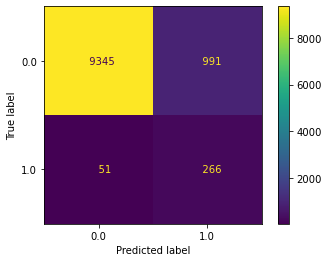

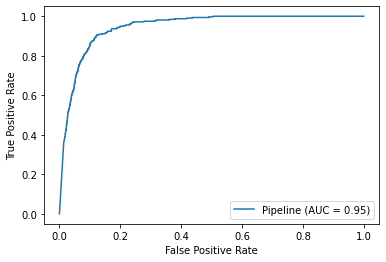

In [12]:
nb = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('nb', MultinomialNB())
])

nb.fit(X_train, y_train)

display_metrics(nb, X_train, X_test, y_train, y_test)

This model is performing decently, but the undersampled logistic regression is our best model so far. Let's explore one more model type.
#### Decision Tree
The decision tree has a built in class weight hyperparameter, so let's try setting that to 'balanced' and then a different tree using the undersampled data.


Train Accuracy:		1.0
Test Accuracy:		0.9638599455552427

Train Recall:		1.0
Test Recall:		0.38485804416403785

Train Precision:	1.0
Test Precision:		0.391025641025641

Train f1:		1.0
Test f1:		0.38791732909379967

Train ROC-AUC:		1.0
Test ROC-AUC:		0.6832378456114306


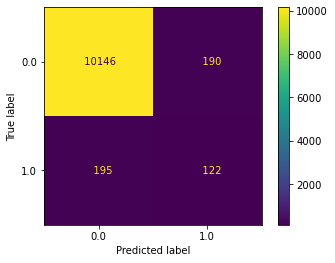

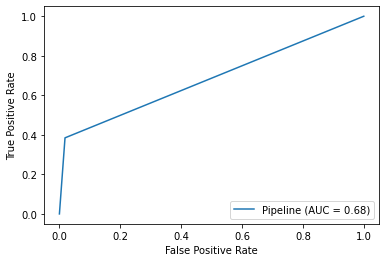

In [13]:
full_tree = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

full_tree.fit(X_train, y_train)
display_metrics(full_tree, X_train, X_test, y_train, y_test)


Train Accuracy:		0.8655422742349334
Test Accuracy:		0.8532807659814137

Train Recall:		1.0
Test Recall:		0.8170347003154574

Train Precision:	0.18121189024390244
Test Precision:		0.14682539682539683

Train f1:		0.3068236812389095
Test f1:		0.248918789043729

Train ROC-AUC:		0.9307091946979714
Test ROC-AUC:		0.8357135575880693


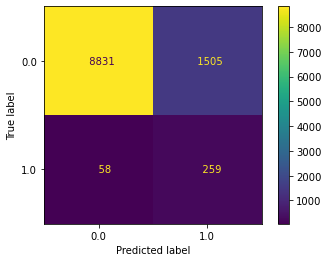

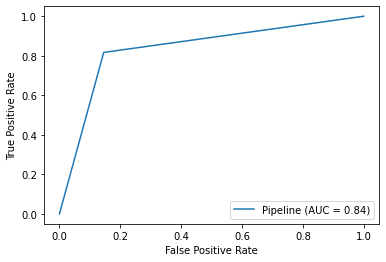

In [14]:
undersampled_tree = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42))
])

undersampled_tree.fit(X_train_undersampled, y_train_undersampled)
display_metrics(undersampled_tree, X_train, X_test, y_train, y_test)

Both of these models are interesting. Decision trees are prone to overfitting, so let's prune the tree to see how promising these really are.

We ran a series of grid searches, the code for which is commented out below.

In [20]:
# unpruned_full_tree = Pipeline(steps=[
#     ('preproc', full_preprocessor),
#     ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
# ])

# full_param_grid = {
#     'tree__criterion': ['gini', 'entropy'],
#     'tree__max_depth': [None,1,2,3,4,5,10,20],
#     'tree__min_samples_leaf': [1,2,3,5,10,20],
#     'tree__min_samples_split': [1,2,3,5,10,20]
# }

# full_grid = GridSearchCV(estimator=unpruned_full_tree, param_grid=full_param_grid,
#                                       n_jobs=-1,
#                                       verbose=1,
#                                       return_train_score=True,
#                                       scoring='recall',
#                                       cv=StratifiedKFold(n_splits=5))

# full_grid.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 13.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('no_pre',
                                                                         Pipeline(steps=[('no_imp',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant'))]),
                                                                         ['SC_SEX',
                                                                          'K4Q32X01',
                                                                          'K4Q32X02',
                                                                          'K4Q32X03',
                                                                          'K4Q32X04',
            

In [21]:
# unpruned_undersampled_tree = Pipeline(steps=[
#     ('preproc', full_preprocessor),
#     ('tree', DecisionTreeClassifier(random_state=42))
# ])

# undersampled_param_grid = {
#     'tree__criterion': ['gini', 'entropy'],
#     'tree__max_depth': [None,1,2,3,4,5,10,20],
#     'tree__min_samples_leaf': [1,2,3,5,10,20],
#     'tree__min_samples_split': [1,2,3,5,10,20]
# }

# undersampled_grid = GridSearchCV(estimator=unpruned_undersampled_tree, param_grid=undersampled_param_grid,
#                                  n_jobs=-1,
#                                  verbose=1,
#                                  return_train_score=True,
#                                  scoring='recall',
#                                  cv=StratifiedKFold(n_splits=5))

# undersampled_grid.fit(X_train_undersampled, y_train_undersampled)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  2.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('no_pre',
                                                                         Pipeline(steps=[('no_imp',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant'))]),
                                                                         ['SC_SEX',
                                                                          'K4Q32X01',
                                                                          'K4Q32X02',
                                                                          'K4Q32X03',
                                                                          'K4Q32X04',
            


Train Accuracy:		0.8611928155704361
Test Accuracy:		0.8617290903970712

Train Recall:		0.943217665615142
Test Recall:		0.9369085173501577

Train Precision:	0.16991854517901117
Test Precision:		0.1697142857142857

Train f1:		0.28796147672552164
Test f1:		0.28737300435413643

Train ROC-AUC:		0.9586972949393707
Test ROC-AUC:		0.9449063516324677


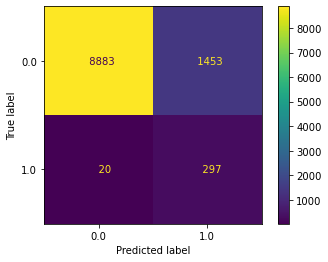

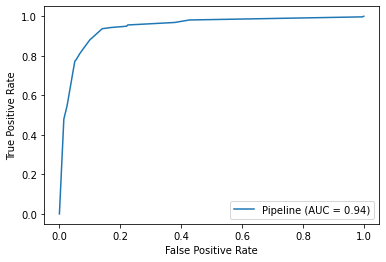

In [22]:
# full_grid_tree = full_grid.best_estimator_

# full_grid_tree.fit(X_train, y_train)

# display_metrics(full_grid_tree, X_train, X_test, y_train, y_test)


Train Accuracy:		0.8010200888666374
Test Accuracy:		0.7992114897212053

Train Recall:		0.943217665615142
Test Recall:		0.9400630914826499

Train Precision:	0.12454873646209386
Test Precision:		0.12324234904880066

Train f1:		0.22004170244081933
Test f1:		0.2179159049360146

Train ROC-AUC:		0.9196042432262421
Test ROC-AUC:		0.9109586658007052


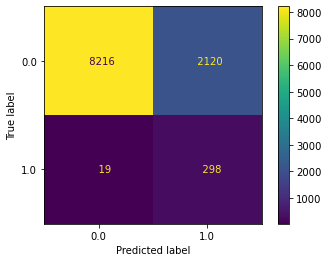

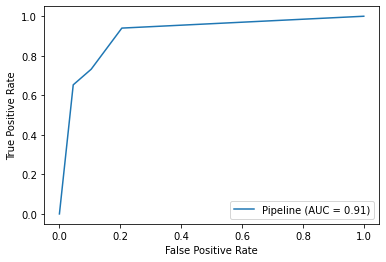

In [23]:
# undersampled_grid_tree = undersampled_grid.best_estimator_

# undersampled_grid_tree.fit(X_train_undersampled, y_train_undersampled)

# display_metrics(undersampled_grid_tree, X_train, X_test, y_train, y_test)

In [24]:
# full_params = full_grid.best_params_
# undersampled_params= undersampled_grid.best_params_

# print(f'{full_params}\n\n{undersampled_params}')

{'tree__criterion': 'entropy', 'tree__max_depth': 4, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}

{'tree__criterion': 'entropy', 'tree__max_depth': 2, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}



Train Accuracy:		0.8611928155704361
Test Accuracy:		0.8617290903970712

Train Recall:		0.943217665615142
Test Recall:		0.9369085173501577

Train Precision:	0.16991854517901117
Test Precision:		0.1697142857142857

Train f1:		0.28796147672552164
Test f1:		0.28737300435413643

Train ROC-AUC:		0.9586972949393707
Test ROC-AUC:		0.9449063516324677


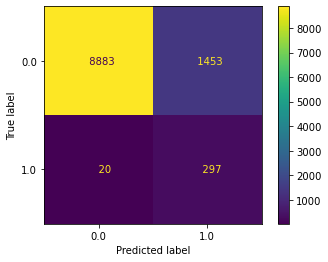

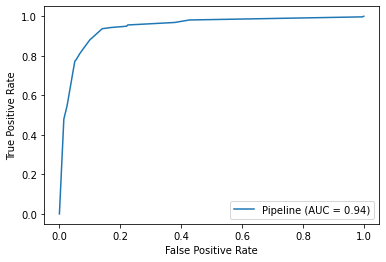

In [31]:
pruned_full_tree = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                    criterion='entropy',
                                    max_depth=4, min_samples_leaf=1, min_samples_split=2))
])

pruned_full_tree.fit(X_train, y_train)

display_metrics(pruned_full_tree, X_train, X_test, y_train, y_test)


Train Accuracy:		0.8010200888666374
Test Accuracy:		0.7992114897212053

Train Recall:		0.943217665615142
Test Recall:		0.9400630914826499

Train Precision:	0.12454873646209386
Test Precision:		0.12324234904880066

Train f1:		0.22004170244081933
Test f1:		0.2179159049360146

Train ROC-AUC:		0.9196042432262421
Test ROC-AUC:		0.9109586658007052


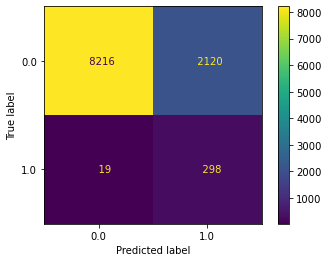

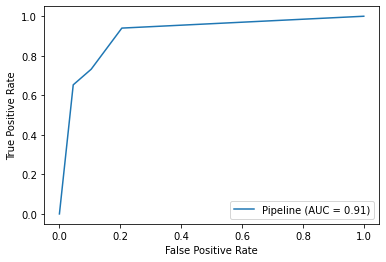

In [30]:
pruned_undersampled_tree = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42,
                                    criterion='entropy',
                                    max_depth=2, min_samples_leaf=1, min_samples_split=2))
])

pruned_undersampled_tree.fit(X_train_undersampled, y_train_undersampled)

display_metrics(pruned_undersampled_tree, X_train, X_test, y_train, y_test)

In [36]:
full_feature_importance = dict(zip(use_cols, pruned_full_tree['tree'].feature_importances_))
for key, val in full_feature_importance.items():
    if val > 0:
        print(key, val)

K2Q36A 0.042778836614023326
K2Q36B 0.023778857771937587
K4Q36 0.6502116326015883
SC_CSHCN 0.10949772167096064
SC_AGE_YEARS 0.009525473041151998
HCABILITY 0.022956604753557965
MAKEFRIEND 0.13669565002153863
MENBEVCOV 0.004555223525241631


In [37]:
undersampled_feature_importance = dict(zip(use_cols, pruned_undersampled_tree['tree'].feature_importances_))
for key, val in undersampled_feature_importance.items():
    if val > 0:
        print(key, val)

K4Q36 0.7662678525243051
SC_K2Q22 0.23373214747569498


So our gridsearch returned models that have pretty good recall scores, but very low precision. Since precision is an unreliable metric, we don't mind this; but it is something to improve on where possible.

Next step is to explore feature importances. Since the undersampled model had a lower depth it only used 2 features.